In [1]:
#this is taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
from collections import namedtuple

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)

class ReplayMemory:
    """
    Record past experiences for learning.
    """
    def __init__(self, capacity=2000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = Transition(
            *(np.array(el).reshape(batch_size, -1) for el in zip(*batch))
        )
        return batch

    def __len__(self):
        return len(self.memory)


In [34]:
import random
import numpy as np
import numpy.matlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers


class DQNAgent():
    def __init__(self, env, epsilon=1.0, lr=0.5, batch_size=128):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        self.memory = ReplayMemory()
        self.epsilon = epsilon   # exploration factor
        self.lr = lr       # Learning rate
        self.batch_size = batch_size
        self.model = self._build_model()
        self.losses = []
    
    def _build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(
                100,
                input_shape=(4,),
                kernel_initializer=initializers.RandomNormal(stddev=5.0),
                bias_initializer=initializers.Ones(),
                # kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activation='sigmoid',
                name='state'
            ),
            layers.Dense(
                2,
                #input_shape=(4,),
                activation='relu'
            ),
            layers.Dense(1, name='action', activation='tanh'),
        ])
        model.summary()
        model.compile(
            loss='hinge',
            optimizer=optimizers.RMSprop(lr=self.lr)
        )
        return model
       
    def encode(self, state, action=None):
        if action is None:
            action = np.reshape(
                list(range(self.action_size)),
                (self.action_size, 1)
            )
            return np.hstack([
                np.matlib.repmat(state, self.action_size, 1),
                action
            ])
        return np.hstack([state, action])

    def play(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """
        state = np.reshape(state, (1, 3)).astype(float)
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(0, self.action_size)
        else:
            action_value = self.model.predict(self.encode(state)).squeeze()
            action = np.argmax(action_value)
        
        next_state1, reward, done, _ = self.env.step(action)
        next_state = np.reshape(next_state1, (1, 3)).astype(float)
        if done:
            self.memory.push(state, action, next_state, reward)
        return next_state1, reward, done

    def learn(self):
        effective_batch_size = min([len(self.memory), self.batch_size])
        if effective_batch_size < 10:
            return
        #self.model.optimizer.set_state()
        prev_loss = None
        loss = None
        patience = 0
        i = 0
        #while patience < 2 and i < 10:
        batch = self.memory.sample(effective_batch_size)
        # for more complex games we could take a wider horizon, like this:
        #pred_rewards = self.model.predict(
        #    self.encode(batch.next_state)
        #).max(axis=1).reshape(self.batch_size, 1)
        #learn_signal = batch.reward# + pred_rewards * self.gamma
        #target = self.model.predict(
        #    self.encode(batch.state))
        #np.put_along_axis(
        #    arr=target,
        #    indices=batch.action,
        #    values=learn_signal,
        #    axis=1
        #)
        result = self.model.fit(
            self.encode(batch.state, batch.action),
            batch.reward,
            epochs=1,
            verbose=0
        )
        prev_loss = loss
        loss = result.history['loss'][-1]
        if prev_loss is not None and loss > prev_loss:
            patience += 1
        else:
            patience = 0
        i += 1
        
        self.losses.append(loss)


In [35]:
import gym
env = gym.make('Blackjack-v0')

In [36]:
agent = DQNAgent(env=env, epsilon=0.01, lr=0.01, batch_size=1000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (Dense)                (None, 100)               500       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
_________________________________________________________________
action (Dense)               (None, 1)                 3         
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [37]:
agent.memory.capacity = 20000

In [38]:
agent.batch_size = 1000

In [39]:
from tqdm.notebook import trange

num_rounds = 5000
exploit_runs = num_rounds // 5
best_100 = -1.0

payouts = []
epsilons = np.hstack([
    np.linspace(0.5, 0.01, num=num_rounds - exploit_runs), 
    np.zeros(exploit_runs)
])
for sample in trange(num_rounds):
    epsilon = epsilons[sample]
    agent.epsilon = epsilon
    total_payout = 0
    state = agent.env.reset()
    for _ in range(10):
        state, payout, done = agent.play(state)
        total_payout += payout
        if done:
            break
    if epsilon > 0:
        agent.learn()
    
    mean_100 = np.mean(payouts[-100:])
    if mean_100 > best_100:
        best_100 = mean_100

    payouts.append(total_payout)
    if (sample % 100) == 0 and sample >= 100:
        
        print('average payout: {:.3f}'.format(
            mean_100
        ))
        print(agent.losses[-1])
        
print('best 100 average: {:.3f}'.format(best_100))

average payout: -0.420
0.5941007137298584
average payout: -0.130
0.7313433885574341
average payout: -0.240
0.7409286499023438
average payout: -0.220
0.7457007765769958
average payout: -0.240
0.7485693693161011
average payout: -0.270
0.7466313242912292
average payout: -0.240
0.7475041151046753
average payout: -0.370
0.7353308200836182
average payout: -0.420
0.715871274471283
average payout: -0.290
0.7160000205039978
average payout: -0.220
0.734000027179718
average payout: -0.290
0.7020000219345093
average payout: -0.410
0.7129999995231628
average payout: -0.300
0.703000009059906
average payout: -0.100
0.7149999737739563
average payout: -0.120
0.7139999866485596
average payout: -0.360
0.722000002861023
average payout: -0.370
0.7160000205039978
average payout: -0.190
0.7360000014305115
average payout: -0.120
0.718999981880188
average payout: -0.080
0.7149999737739563
average payout: -0.190
0.7590000033378601
average payout: -0.370
0.7710000276565552
average payout: 0.000
0.751999974250793

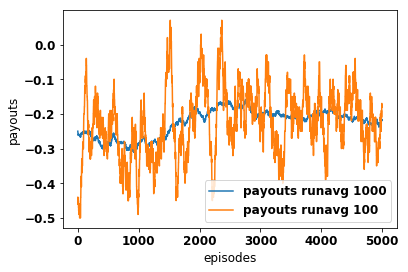

In [40]:
%matplotlib inline
from scipy.ndimage.filters import uniform_filter1d
import matplotlib
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

#plt.plot(payouts)           
plt.xlabel('episodes')
plt.ylabel('payouts')
plt.plot(uniform_filter1d(payouts, size=1000))
plt.plot(uniform_filter1d(payouts, size=100))
#plt.plot(uniform_filter1d(agent.losses, size=100))
plt.legend([
    'payouts runavg 1000',
    'payouts runavg 100',
    #'training losses runavg 100',
])